## Student Information

In [1]:
# Student Name: Daniel Nemirovskiy, Nathan Seaney
# Student ID: DEN200001, NES210004
# Course Name: CS 4375-002

## Importing Necessary Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy
import random
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

## Setting GPU

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2.7.0+cpu
None
None
False
Using device: cpu


## Creating Directories for Results

In [4]:
os.makedirs('./results', exist_ok=True)
os.makedirs('./results/runs', exist_ok=True)

## Obtaining the Datasets

In [5]:
def get_datasets(dataset_name, batch_size=32, num_workers=2):
    """
    Load and preprocess datasets. Split training data into train and validation sets.
    """
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # loading the dataset
    if dataset_name.lower() == 'cifar10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                                    download=True, transform=transform_train)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                                   download=True, transform=transform_test)
        dataset_info = {
            'name': 'CIFAR-10',
            'num_classes': 10,
            'classes': ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
            'input_channels': 3,
            'input_shape': (32, 32)
        }
        
    elif dataset_name.lower() == 'svhn':
        train_dataset = torchvision.datasets.SVHN(root='./data', split='train',
                                                download=True, transform=transform_train)
        test_dataset = torchvision.datasets.SVHN(root='./data', split='test',
                                               download=True, transform=transform_test)
        dataset_info = {
            'name': 'SVHN',
            'num_classes': 10,
            'classes': tuple(str(i) for i in range(10)),  # Digits 0-9
            'input_channels': 3,
            'input_shape': (32, 32)
        }
    else:
        raise ValueError(f"Dataset {dataset_name} not supported. Use 'cifar10' or 'svhn'.")
    
    # split training data into training and validation sets 90% train and 10% validation
    val_size = int(0.1 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
    
    # data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_subset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)

    # outputting number of samples for each subset
    print(f"Dataset: {dataset_info['name']}")
    print(f"Number of training samples: {len(train_subset)}")
    print(f"Number of validation samples: {len(val_subset)}")
    print(f"Number of testing samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader, dataset_info

## Visualizing the Data Samples

In [6]:
def visualize_dataset_samples(loader, classes, num_samples=5):
    """
    Visualize samples from a dataset.
    """
    samples, labels = next(iter(loader))
    
    # moving samples to CPU and convert to numpy
    samples = samples.cpu().numpy()
    
    # unnormalizing images
    samples = samples / 2 + 0.5
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(samples))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.transpose(samples[i], (1, 2, 0)))
        plt.title(classes[labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Implementing the LeNet Model

In [7]:
class LeNet(nn.Module):
    """
    LeNet-5 CNN architecture
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(LeNet, self).__init__()
        # first convolutional layer with 6 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # second convolutional layer with 16 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # first convolutional block
        x = self.pool1(F.relu(self.conv1(x)))
        
        # second convolutional block
        x = self.pool2(F.relu(self.conv2(x)))
        
        # flattening
        x = x.view(x.size(0), -1)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# testing the model
def test_lenet():
    model = LeNet()
    sample_input = torch.randn(1, 3, 32, 32)
    output = model(sample_input)
    print(f"LeNet Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing the ResNet-18 Model

In [8]:
class BasicBlock(nn.Module):
    """
    Basic block for ResNet-18 and ResNet-34
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # shortcut connection
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet18(nn.Module):
    """
    ResNet-18 implementation
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(ResNet18, self).__init__()
        
        # first convolutional layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # four layers of the network with multiple residual blocks
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        # global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Creating a layer of residual blocks
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # first convolution
        out = F.relu(self.bn1(self.conv1(x)))
        
        # ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # global average pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        # fcl
        out = self.fc(out)
        
        return out

# testing the model
def test_resnet18():
    model = ResNet18()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"ResNet-18 Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing our Custom FCNN

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        # initial Downsampling using strided convolution instead of max pooling
        self.conv1 = nn.Conv2d(3, 24, kernel_size=7, stride=2, padding=3)
        self.act1 = nn.GELU()  # Non-standard activation for diversity

        # depthwise separable convolution block
        self.dwconv2 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, groups=24)
        self.pwconv2 = nn.Conv2d(24, 48, kernel_size=1)
        self.act2 = nn.GELU()

        # dilated convolution block (to capture context without downsampling)
        self.dilated_conv = nn.Conv2d(48, 64, kernel_size=3, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.SiLU()

        # global average pooling instead of flatten + dense
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # classifier
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))

        x = self.act2(self.pwconv2(self.dwconv2(x)))

        x = self.act3(self.bn3(self.dilated_conv(x)))

        x = self.global_avg_pool(x) 
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)

        return x

# testing the model
def test_customcnn():
    model = CustomCNN(
        filters=(16, 32, 64), 
        kernel_sizes=(3, 3, 3), 
        fc_sizes=(128,),
        dropout_rate=0.2,
        use_batch_norm=True
    )
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"CustomCNN Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Model Selector function

In [10]:
def get_model(model_name, num_classes=10, input_channels=3):
    """
    Return model instance based on name.
    """
    if model_name.lower() == 'lenet':
        return LeNet(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'resnet18':
        return ResNet18(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'customcnn':
        return CustomCNN(num_classes=num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported. Use 'lenet', 'resnet18', or 'customcnn'.")


## Defining the Training Function

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, 
               num_epochs=25, model_name="model", dataset_name="dataset",
               scheduler=None, log_step=100, save_dir="./results"):
    """
    Train a model and evaluate on validation set.
    """
    since = time.time()
    
    # setting up the TensorBoard writer
    writer = SummaryWriter(f"{save_dir}/runs/{model_name}_{dataset_name}")
    
    # initializing training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # copy initial weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # train loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # splitting training and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterating over batches
            data_iterator = tqdm(dataloaders[phase], desc=f'{phase} - Epoch {epoch+1}/{num_epochs}')
            for i, (inputs, labels) in enumerate(data_iterator):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward pass + optimize, only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        # logging to TensorBoard
                        global_step = epoch * len(dataloaders['train']) + i
                        if global_step % log_step == 0:
                            writer.add_scalar(f'Loss/{phase}', loss.item(), global_step)
                
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # updating the learning rate if scheduler is provided
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            # calculating epoch statistics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # logging epoch statistics
            writer.add_scalar(f'Epoch_Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Epoch_Accuracy/{phase}', epoch_acc, epoch)
            
            # history updates
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # outputting loss and accuracy of epoch
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # saving the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': best_acc,
                }, f"{save_dir}/{model_name}_{dataset_name}_best.pth")
        
        # checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f"{save_dir}/{model_name}_{dataset_name}_checkpoint.pth")
        
        print()
    
    # calculating total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # adding model graph to TensorBoard
    writer.add_graph(model, next(iter(dataloaders['train']))[0].to(device))
    writer.close()
    
    # loading best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Evaluating the Models

In [12]:
def evaluate_model(model, dataloader, criterion, device, dataset_name="dataset"):
    """
    Evaluate a model on test set
    """
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # iterating over batches
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Evaluating on {dataset_name}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # stats
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # storing predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # stats
    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)

    # outputting loss and accuracy for evaluation
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc.item(), all_preds, all_labels

## Plotting the Training History and Confusion Matrix

In [13]:
def plot_training_history(history, title, save_dir="./results"):
    """
    Plot training and validation loss and accuracy curves
    """
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plotting loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # plotting accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # saving plotted visualizations to file for report
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_history.png")
    plt.show()
    
    print(f"Training history plot saved to {save_dir}/{title.replace(' ', '_')}_history.png")

def plot_confusion_matrix(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Plot confusion matrix
    """
    # computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    # creating a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # adding labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # saving matrix visualiation
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    
    print(f"Confusion matrix plot saved to {save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")


## Defining the Classification Report Function

In [14]:
def generate_classification_report(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Generate and save classification report
    """
    # generating the classification report
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    # converting to dataframe for visualization
    df_report = pd.DataFrame(report).transpose()
    
    # saving report to CSV
    os.makedirs(save_dir, exist_ok=True)
    df_report.to_csv(f"{save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    print(f"Classification report saved to {save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    return df_report

## Model Comparison

In [15]:
def compare_models(results, title, save_dir="./results"):
    """
    Generate bar plots comparing different models
    """
    # extracting data
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    losses = [results[model]['loss'] for model in models]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # plotting accuracy
    bars1 = ax1.bar(models, accuracies, color='skyblue')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.0)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # plotting loss
    bars2 = ax2.bar(models, losses, color='salmon')
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Loss')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # saving the comparison
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_comparison.png")
    plt.show()
    
    print(f"Model comparison plot saved to {save_dir}/{title.replace(' ', '_')}_comparison.png")


## Running the Final Tests

In [16]:
def run_experiment(dataset_names=['cifar10', 'svhn'], 
                  model_names=['lenet', 'resnet18', 'customcnn'],
                  batch_size=128, epochs=30, learning_rate=0.001, weight_decay=1e-4,
                  num_workers=2, save_dir='./results', log_step=100):
    """
    Run the complete experiment pipeline.
    """
    # results dictionary to store metrics for all models and datasets
    results = defaultdict(dict)
    
    # iterating over each dataset
    for dataset_name in dataset_names:
        print(f"\n{'='*50}")
        print(f"Processing dataset: {dataset_name}")
        print(f"{'='*50}")
        
        # load the dataset
        train_loader, val_loader, test_loader, dataset_info = get_datasets(
            dataset_name, batch_size=batch_size, num_workers=num_workers
        )
        
        # visualizing samples
        visualize_dataset_samples(train_loader, dataset_info['classes'])
        
        # creating dataloader dictionary
        dataloaders = {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }
        
        # iterating over the models
        for model_name in model_names:
            print(f"\n{'-'*40}")
            print(f"Training {model_name} on {dataset_name}")
            print(f"{'-'*40}")
            
            # model initialization
            model = get_model(
                model_name, 
                num_classes=dataset_info['num_classes'],
                input_channels=dataset_info['input_channels']
            )
            model = model.to(device)
            
            # printing # of params for model
            print(f"Model: {model_name}")
            print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
            
            # defining loss and optimization functions
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            # learning rate scheduler
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            
            # training the model
            model, history = train_model(
                model, dataloaders, criterion, optimizer, device,
                num_epochs=epochs, model_name=model_name, dataset_name=dataset_name,
                scheduler=scheduler, log_step=log_step, save_dir=save_dir
            )
            
            # plotting history
            plot_training_history(
                history, f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # model evaluation on test set
            test_loss, test_acc, test_preds, test_labels = evaluate_model(
                model, test_loader, criterion, device, dataset_name=dataset_name
            )
            
            # storing results
            results[dataset_name][model_name] = {
                'accuracy': test_acc,
                'loss': test_loss
            }
            
            # plotting confusion matrix
            plot_confusion_matrix(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # generating classification report
            report_df = generate_classification_report(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            print("\nClassification Report:")
            display(report_df)
            
        # model comparison by dataset
        compare_models(
            results[dataset_name], f"Model Comparison on {dataset_name}", save_dir=save_dir
        )
    
    # outputting final results
    print("\nFinal Results:")
    for dataset_name in dataset_names:
        print(f"\nDataset: {dataset_name}")
        for model_name in model_names:
            print(f"  {model_name}: Accuracy = {results[dataset_name][model_name]['accuracy']:.4f}, "
                  f"Loss = {results[dataset_name][model_name]['loss']:.4f}")
    
    return results

## Evaluating Trained Models

In [17]:
def evaluate_trained_model(model_name, dataset_name, checkpoint_path):
    """
    Evaluate a trained model on test data.
    """
    # loading the dataset
    _, _, test_loader, dataset_info = get_datasets(
        dataset_name, batch_size=128, num_workers=2
    )
    
    # model initialization
    model = get_model(
        model_name, 
        num_classes=dataset_info['num_classes'],
        input_channels=dataset_info['input_channels']
    )
    model = model.to(device)
    
    # loading checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    # defining the loss function
    criterion = nn.CrossEntropyLoss()
    
    # evaluating the model on test set
    test_loss, test_acc, test_preds, test_labels = evaluate_model(
        model, test_loader, criterion, device, dataset_name=dataset_name
    )
    
    # plotting the confusion matrix
    plot_confusion_matrix(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    # generating a classification report
    report_df = generate_classification_report(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    print("\nClassification Report:")
    display(report_df)
    
    return test_acc, test_loss

## Running the Experiment


Processing dataset: cifar10
Dataset: CIFAR-10
Number of training samples: 45000
Number of validation samples: 5000
Number of testing samples: 10000


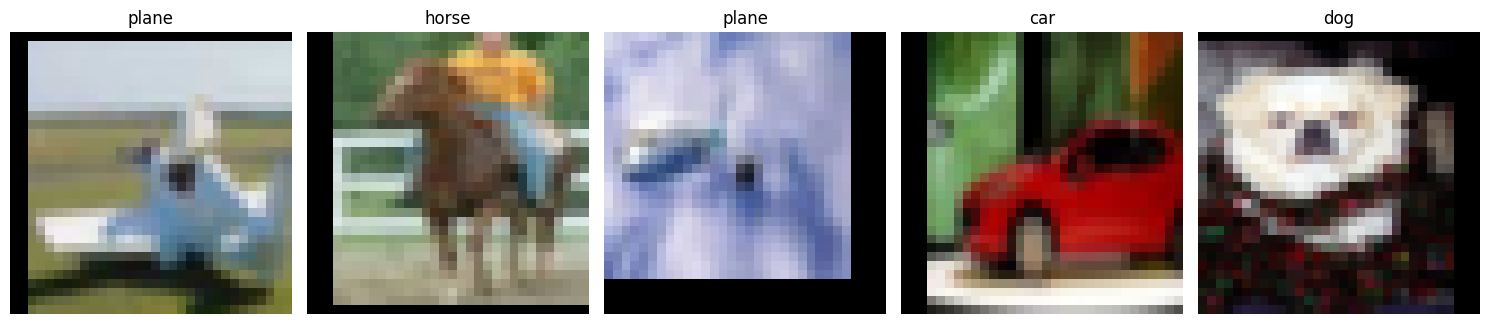

Showing 5 sample images from dataset

----------------------------------------
Training customcnn on cifar10
----------------------------------------
Model: customcnn
Number of parameters: 33482
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.9149 Acc: 0.2822


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7408 Acc: 0.3604

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.6875 Acc: 0.3690


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6220 Acc: 0.3972

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.6009 Acc: 0.4059


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5587 Acc: 0.4222

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5413 Acc: 0.4315


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4852 Acc: 0.4554

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4926 Acc: 0.4552


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4542 Acc: 0.4802

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4459 Acc: 0.4763


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3868 Acc: 0.5020

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4065 Acc: 0.4910


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3549 Acc: 0.5108

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3677 Acc: 0.5120


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3061 Acc: 0.5330

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3518 Acc: 0.5139


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2929 Acc: 0.5378

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3458 Acc: 0.5174


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2936 Acc: 0.5412

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3421 Acc: 0.5226


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2883 Acc: 0.5468

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3362 Acc: 0.5220


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2803 Acc: 0.5420

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3315 Acc: 0.5242


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2797 Acc: 0.5430

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3301 Acc: 0.5268


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2763 Acc: 0.5466

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3242 Acc: 0.5259


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2731 Acc: 0.5496

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3201 Acc: 0.5272


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2784 Acc: 0.5384

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3190 Acc: 0.5272


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2677 Acc: 0.5478

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3167 Acc: 0.5294


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2696 Acc: 0.5446

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3232 Acc: 0.5280


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2719 Acc: 0.5512

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3164 Acc: 0.5311


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2667 Acc: 0.5546

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3225 Acc: 0.5266


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2704 Acc: 0.5502

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3143 Acc: 0.5300


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2648 Acc: 0.5482

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3169 Acc: 0.5307


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2707 Acc: 0.5500

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3181 Acc: 0.5300


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2669 Acc: 0.5482

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3193 Acc: 0.5295


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2658 Acc: 0.5520

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3153 Acc: 0.5324


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2673 Acc: 0.5490

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3182 Acc: 0.5303


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2694 Acc: 0.5480

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3144 Acc: 0.5318


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2693 Acc: 0.5510

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3176 Acc: 0.5290


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2653 Acc: 0.5488

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3153 Acc: 0.5302


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2703 Acc: 0.5468

Training complete in 20m 37s
Best val Acc: 0.5546


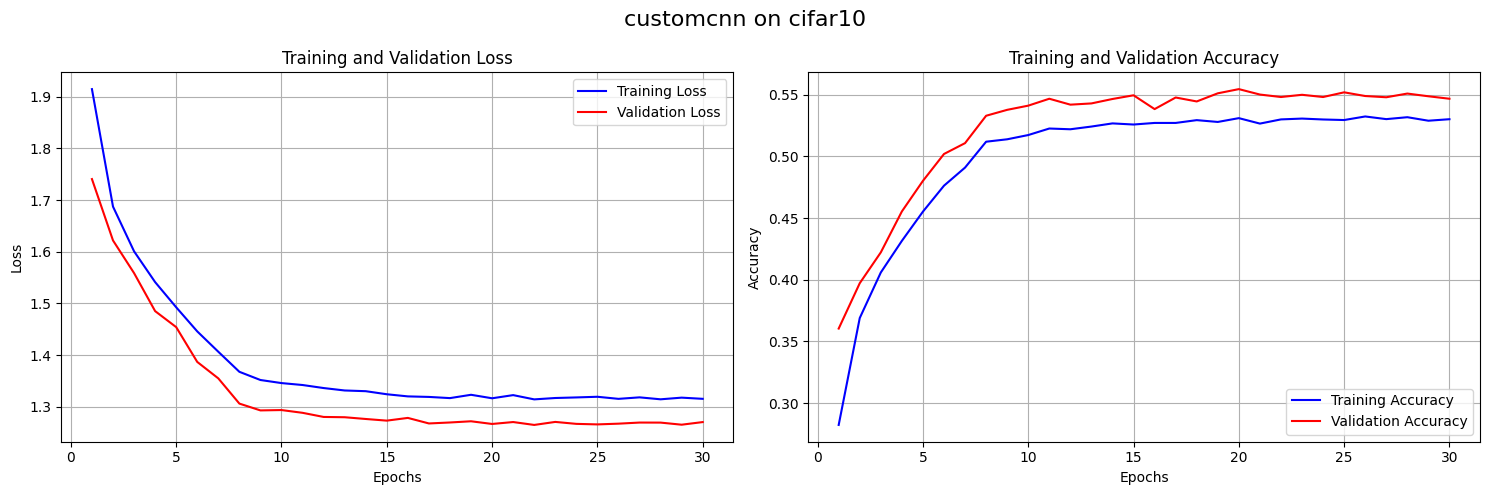

Training history plot saved to ./results/customcnn_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.2497 Acc: 0.5466


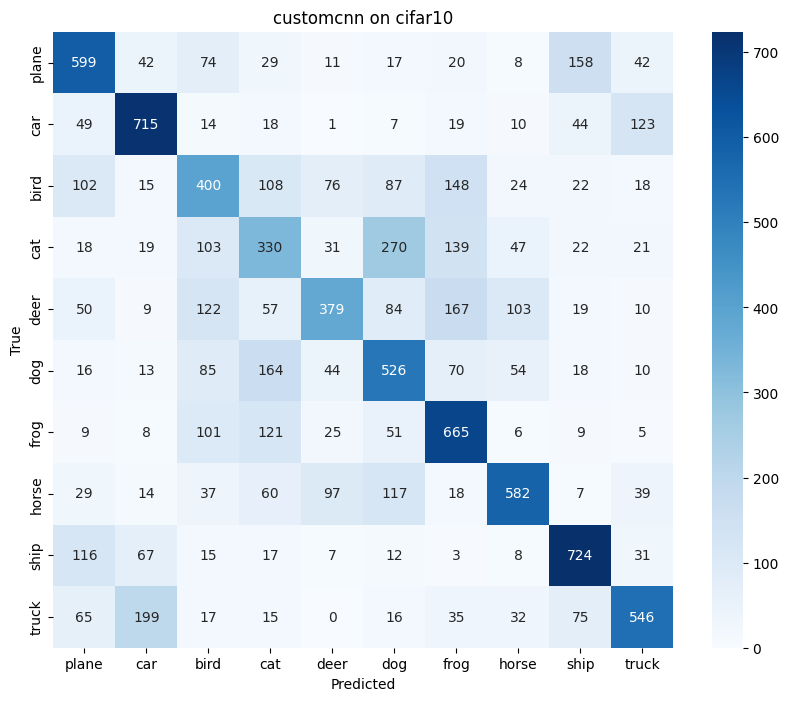

Confusion matrix plot saved to ./results/customcnn_on_cifar10_confusion_matrix.png
Classification report saved to ./results/customcnn_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.568851,0.5990,0.583536,1000.0000
car,0.649410,0.7150,0.680628,1000.0000
bird,0.413223,0.4000,0.406504,1000.0000
cat,0.359086,0.3300,0.343929,1000.0000
deer,0.564829,0.3790,0.453621,1000.0000
dog,0.443134,0.5260,0.481024,1000.0000
frog,0.517913,0.6650,0.582312,1000.0000
horse,0.665904,0.5820,0.621131,1000.0000
ship,0.659381,0.7240,0.690181,1000.0000
truck,0.646154,0.5460,0.591870,1000.0000


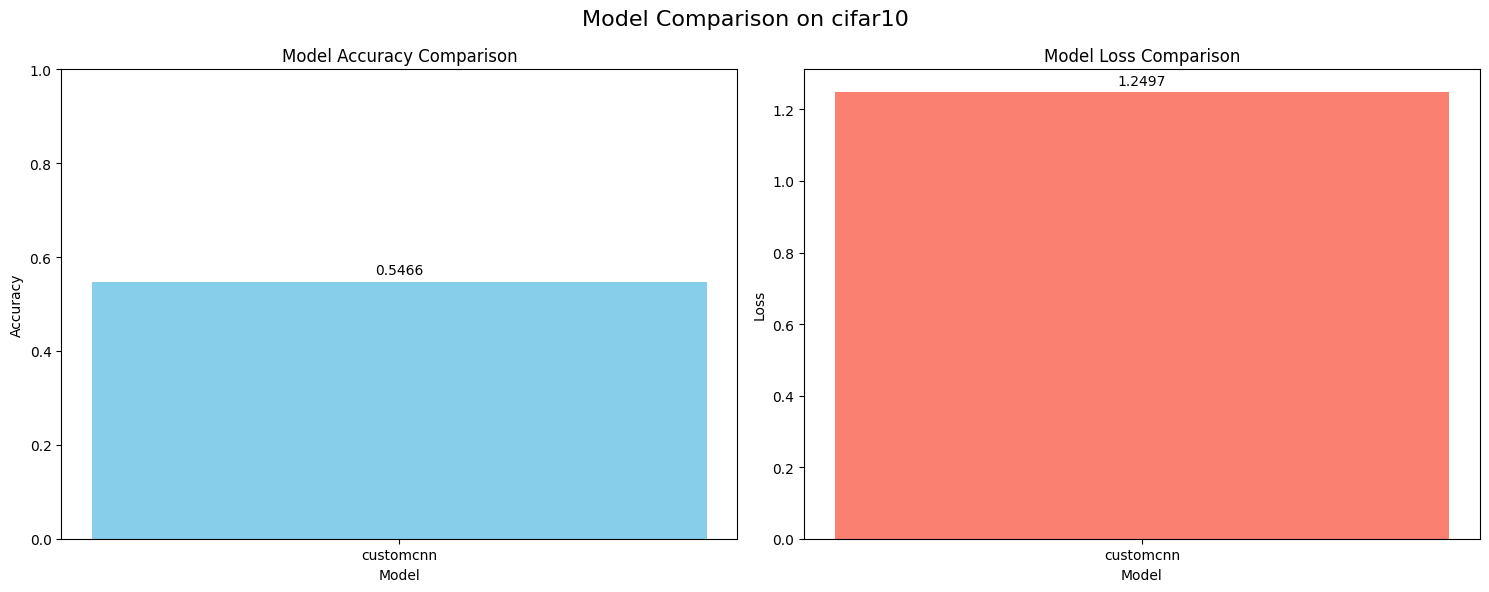

Model comparison plot saved to ./results/Model_Comparison_on_cifar10_comparison.png

Processing dataset: svhn
Dataset: SVHN
Number of training samples: 65932
Number of validation samples: 7325
Number of testing samples: 26032


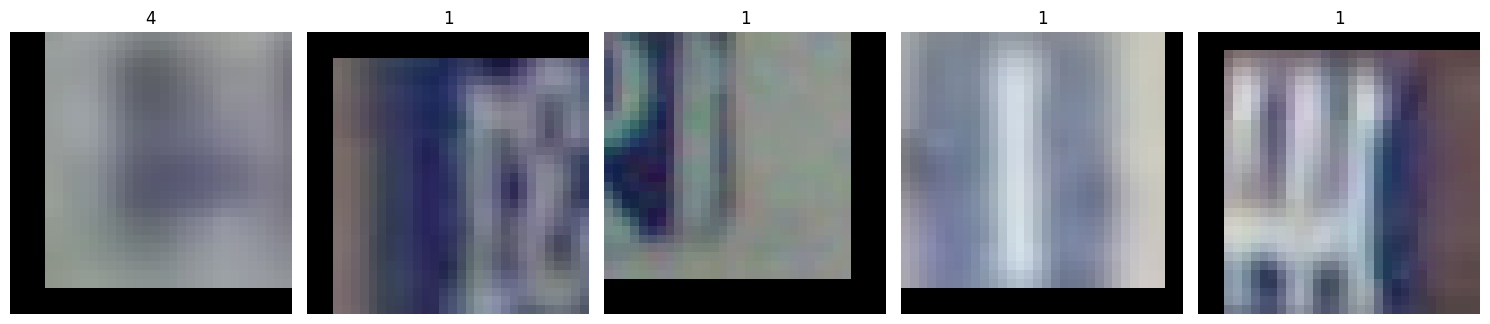

Showing 5 sample images from dataset

----------------------------------------
Training customcnn on svhn
----------------------------------------
Model: customcnn
Number of parameters: 33482
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 2.2014 Acc: 0.2100


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 2.0902 Acc: 0.2598

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.9784 Acc: 0.2941


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.8980 Acc: 0.3286

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.8215 Acc: 0.3597


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.7840 Acc: 0.3773

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.6727 Acc: 0.4271


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.6430 Acc: 0.4408

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.5130 Acc: 0.4918


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.3930 Acc: 0.5458

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.3777 Acc: 0.5447


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.3012 Acc: 0.5732

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.2776 Acc: 0.5832


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.1967 Acc: 0.6083

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.2020 Acc: 0.6122


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.1333 Acc: 0.6471

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1894 Acc: 0.6188


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.1216 Acc: 0.6550

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1780 Acc: 0.6189


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.1075 Acc: 0.6539

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1701 Acc: 0.6232


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0938 Acc: 0.6598

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1599 Acc: 0.6287


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0971 Acc: 0.6586

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1532 Acc: 0.6309


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0794 Acc: 0.6610

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1417 Acc: 0.6356


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0710 Acc: 0.6707

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1367 Acc: 0.6357


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0639 Acc: 0.6689

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1356 Acc: 0.6379


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0646 Acc: 0.6688

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1322 Acc: 0.6365


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0623 Acc: 0.6711

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1334 Acc: 0.6362


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0646 Acc: 0.6694

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1350 Acc: 0.6366


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0682 Acc: 0.6722

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1298 Acc: 0.6383


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0609 Acc: 0.6739

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1302 Acc: 0.6384


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0648 Acc: 0.6689

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1306 Acc: 0.6384


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0625 Acc: 0.6662

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1266 Acc: 0.6395


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0592 Acc: 0.6728

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1309 Acc: 0.6370


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0654 Acc: 0.6662

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1307 Acc: 0.6350


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0628 Acc: 0.6650

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1273 Acc: 0.6397


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0704 Acc: 0.6713

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1282 Acc: 0.6382


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0576 Acc: 0.6732

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1285 Acc: 0.6398


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0658 Acc: 0.6695

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1274 Acc: 0.6388


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0606 Acc: 0.6762

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1300 Acc: 0.6370


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0638 Acc: 0.6661

Training complete in 25m 11s
Best val Acc: 0.6762


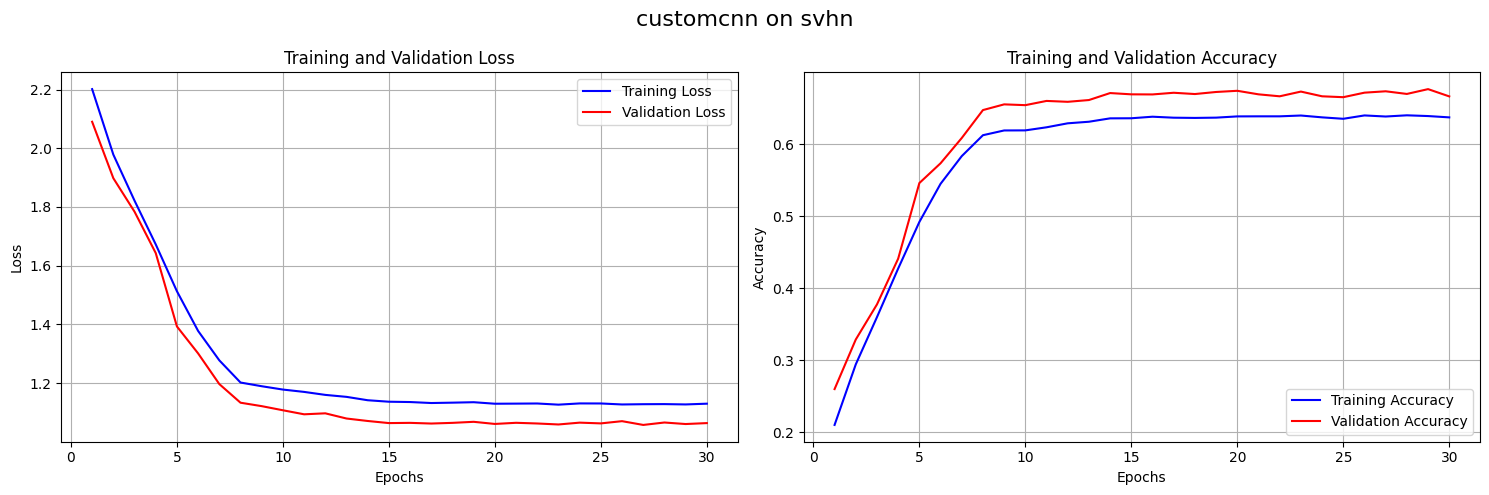

Training history plot saved to ./results/customcnn_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 1.0860 Acc: 0.6409


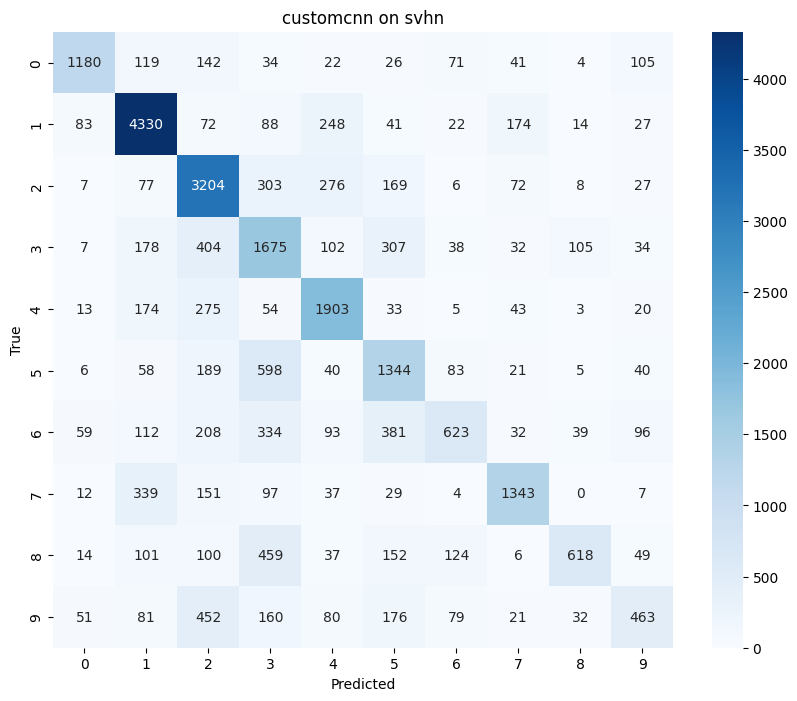

Confusion matrix plot saved to ./results/customcnn_on_svhn_confusion_matrix.png
Classification report saved to ./results/customcnn_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.824022,0.676606,0.743073,1744.000000
1,0.777518,0.849186,0.811774,5099.000000
2,0.616510,0.772234,0.685641,4149.000000
3,0.440558,0.581194,0.501197,2882.000000
4,0.670543,0.754261,0.709942,2523.000000
5,0.505643,0.563758,0.533122,2384.000000
6,0.590521,0.315124,0.410950,1977.000000
7,0.752381,0.665181,0.706099,2019.000000
8,0.746377,0.372289,0.496785,1660.000000
9,0.533410,0.290282,0.375964,1595.000000


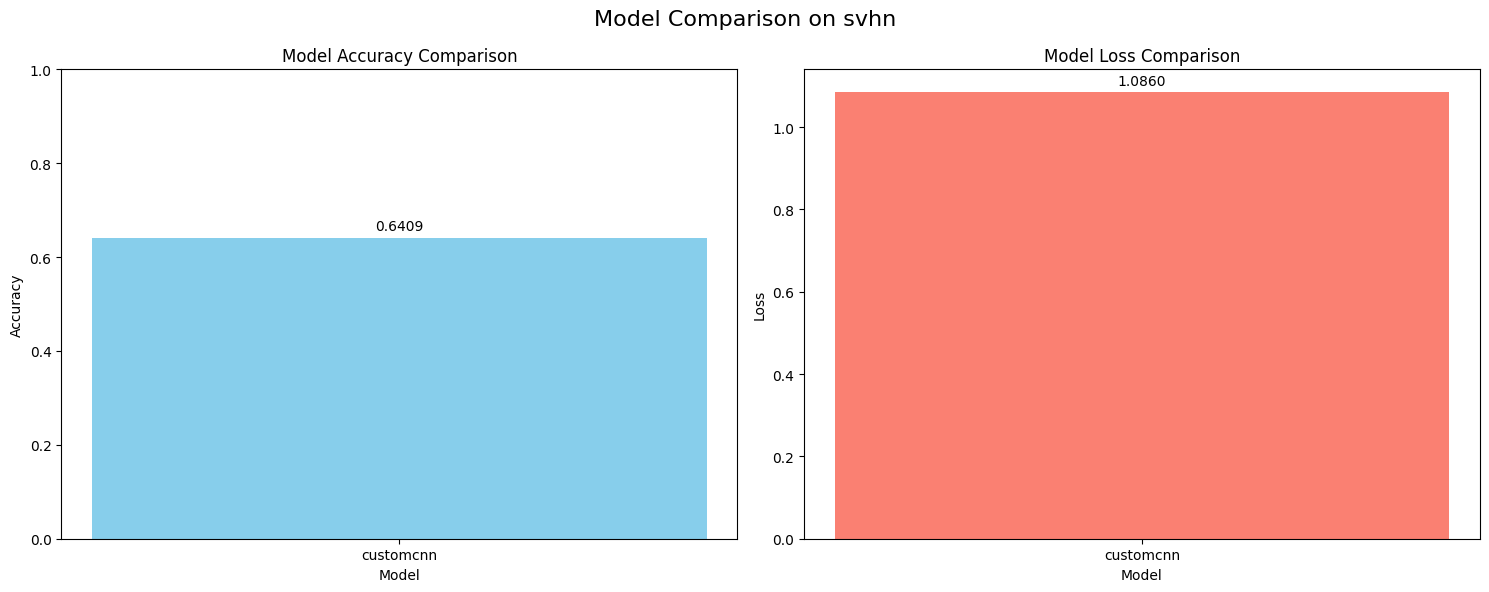

Model comparison plot saved to ./results/Model_Comparison_on_svhn_comparison.png

Final Results:

Dataset: cifar10
  customcnn: Accuracy = 0.5466, Loss = 1.2497

Dataset: svhn
  customcnn: Accuracy = 0.6409, Loss = 1.0860


In [18]:
results = run_experiment(
    dataset_names=['cifar10', 'svhn'],
    model_names=['lenet', 'resnet18', 'customcnn'],
    batch_size=128,
    epochs=30,
    learning_rate=0.001,
    weight_decay=1e-4,
    num_workers=2,
    save_dir='./results'
)